In [1]:
import cdpm
from cdpm import CondDirichletProcessMix
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import tqdm
import pandas as pd

In [2]:
%matplotlib inline
plt.style.use(['seaborn-dark-palette', 'seaborn-poster'])

In [3]:
np.random.seed(10234) # 10037

In [4]:
time_dim = 100
stick_scale = 1
beta_mu, beta_sigma = 0, 0.5 # mean and standard deviation
sigma_df, sigma_scale = 2, 1

In [5]:
cluster_series, alpha_series, beta_mat, sigma_mat = cdpm.simulate_cdpm(time_dim, beta_mu, beta_sigma, stick_scale)

In [6]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'precn': {'scale': [sigma_scale**(-1)], 'shape': [sigma_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [7]:
mean_precn = np.asarray(sigma_scale**(-1) / (sigma_df - 1))

In [8]:
## Initialization
model = CondDirichletProcessMix(beta_mu, tau=mean_precn,regressor=alpha_series[:-1], regressand=alpha_series[1:])
#model.cluster_id = cluster_series[:-1]

## Estimation

In [9]:
num_draws = 3000

In [10]:
cluster_identity_draws = np.empty((num_draws, time_dim))
stick_draws = np.full((num_draws, 30),np.nan)
beta_draws = np.full((num_draws, 30),np.nan)
precision_draws = np.full((num_draws, 30),np.nan)

In [11]:
for draw_idx in tqdm(range(num_draws)):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    stick_draws[draw_idx,:len(model_posterior[1])] = model_posterior[1]
    beta_draws[draw_idx,:len(model_posterior[2])] = np.squeeze(model_posterior[2]) 
    precision_draws[draw_idx,:len(model_posterior[3])] = model_posterior[3]
    

100%|██████████| 3000/3000 [00:02<00:00, 1057.12it/s]


## Simulation Results

In [12]:
percentiles = (1, 5, 25, 50, 75, 95, 99)

In [13]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

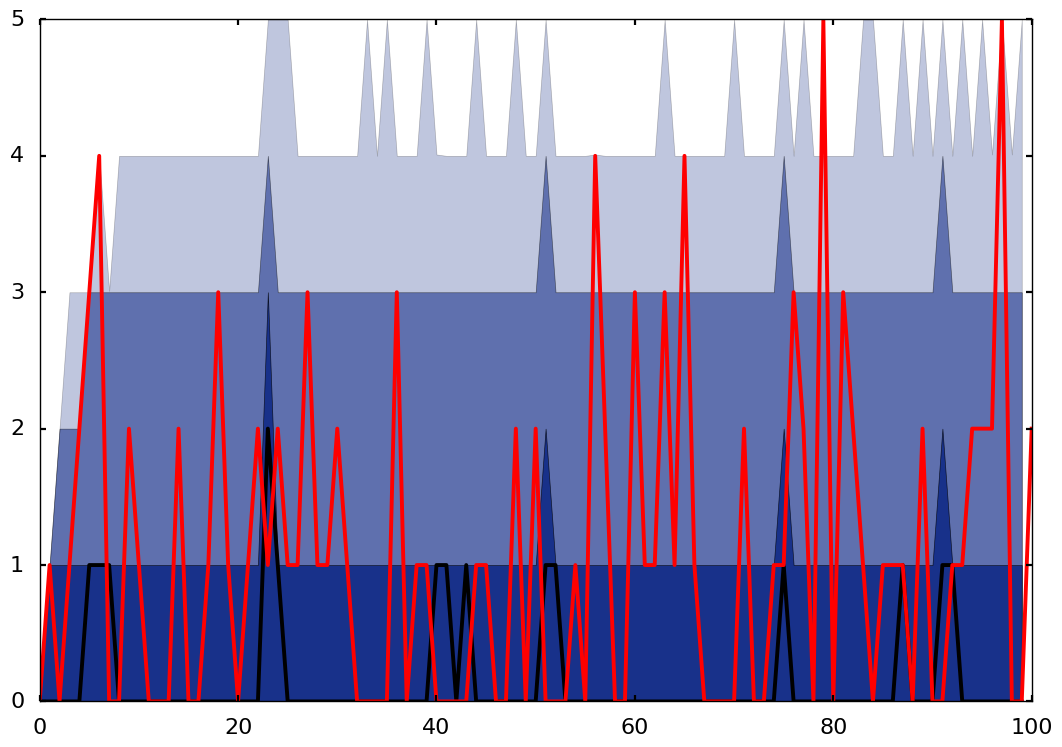

In [14]:
state_comparison_fig, state_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(state_comparison_ax, pd.DataFrame(cluster_identity_draws.T), percentiles, c='black')
state_comparison_ax.plot(cluster_series, c='red')

In [15]:
beta_draws

array([[ 0.07747375,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.04637427,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.0897023 ,         nan,         nan, ...,         nan,
                nan,         nan],
       ..., 
       [-0.380981  ,  0.93807537, -1.11271755, ...,         nan,
                nan,         nan],
       [ 1.28157328,  0.70390134, -1.53343259, ...,         nan,
                nan,         nan],
       [-0.36326292,  0.98624518,  0.93844425, ...,         nan,
                nan,         nan]])

In [16]:
pd.DataFrame(beta_draws).mean()

0     0.034986
1     0.066249
2    -0.009450
3    -0.050493
4    -0.044788
5     0.001079
6     0.029935
7     0.024708
8     0.014273
9    -0.039643
10   -0.150357
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
dtype: float64

In [17]:
beta_mat

array([ 0.2945693 , -0.30860921, -0.64032953,  0.43066411,  0.406196  ,
        0.59172761])

In [18]:
pd.DataFrame(stick_draws).mean()

0     0.668361
1     0.641258
2     0.601315
3     0.586416
4     0.528685
5     0.540796
6     0.484770
7     0.508937
8     0.459666
9     0.437093
10    0.408446
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
dtype: float64

## Get the dynamics of alpha given the estimated clusters/parameters

In [19]:
x = np.array(pd.DataFrame(beta_draws).mean())
x = x[~np.isnan(x)] # get rid of nan's
beta_est = x

y = np.array(pd.DataFrame(precision_draws).mean())
y = y[~np.isnan(y)] # get rid of nan's

sigma_est = 1/y

In [20]:
alpha_est_mat = np.empty((time_dim+1, num_draws))
alpha_est_mat[0] = np.zeros(num_draws)

In [21]:
for t_idx in tqdm(range(time_dim)):
    cl_idx = cluster_identity_draws[:,t_idx].astype(int)
    alpha_f = np.multiply(beta_est[cl_idx],alpha_est_mat[t_idx]) + np.multiply(np.sqrt(sigma_est[cl_idx]), np.random.normal(0,1,num_draws))
    alpha_est_mat[t_idx+1] = alpha_f

100%|██████████| 100/100 [00:00<00:00, 5278.04it/s]


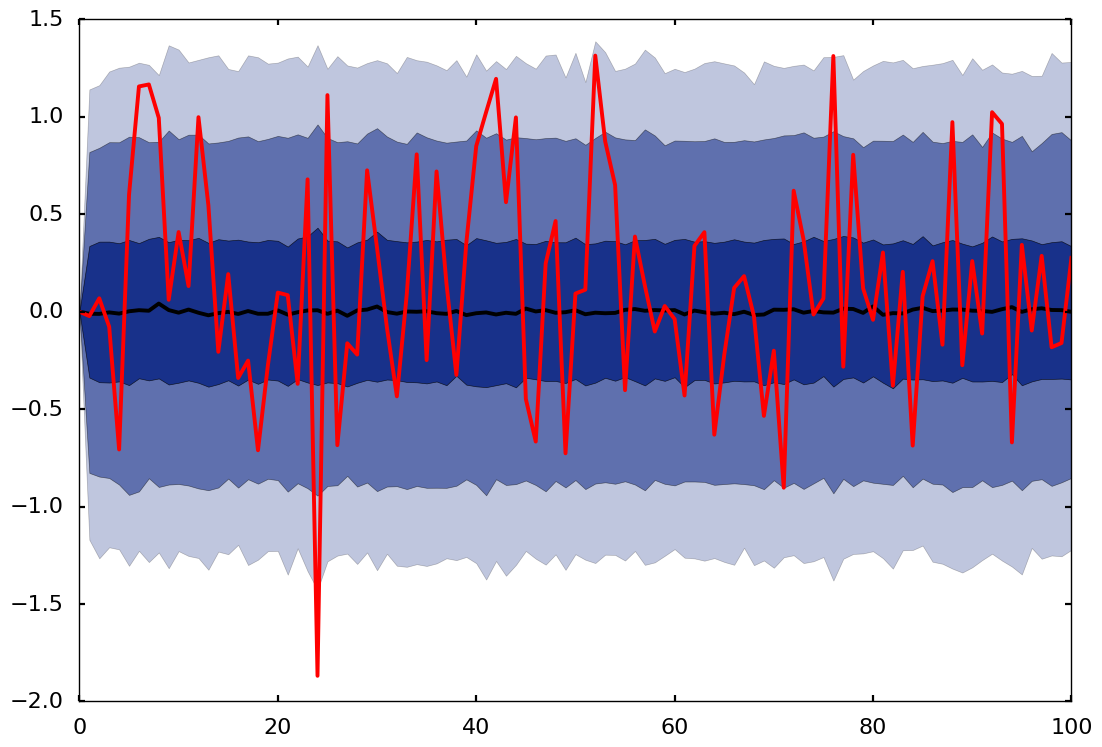

In [22]:
alpha_comparison_fig, alpha_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(alpha_comparison_ax, pd.DataFrame(alpha_est_mat), percentiles, c='black')
alpha_comparison_ax.plot(alpha_series, c='red')